In [1]:
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY
%load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)


# TF2 로 Xception 자체 구현 및 성능 측정 

* 참고 자료 
  * https://www.evernote.com/shard/s193/sh/5cfe5c7f-2695-5c81-5700-9358a7bf1ec7/6150595b1b457c236d49502b9d085cb4
  * https://towardsdatascience.com/xception-from-scratch-using-tensorflow-even-better-than-inception-940fb231ced9



In [29]:
#import necessary libraries

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model


In [30]:
# Conv-Batch block
def conv_bn(x, filters, kernel, strides=1):
    x = Conv2D(filters, kernel, strides, 'same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

# SeperableConv-Batch
def sepconv_bn(x, filters, kernel, strides=1):
    x = SeparableConv2D(filters, kernel, strides, 'same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

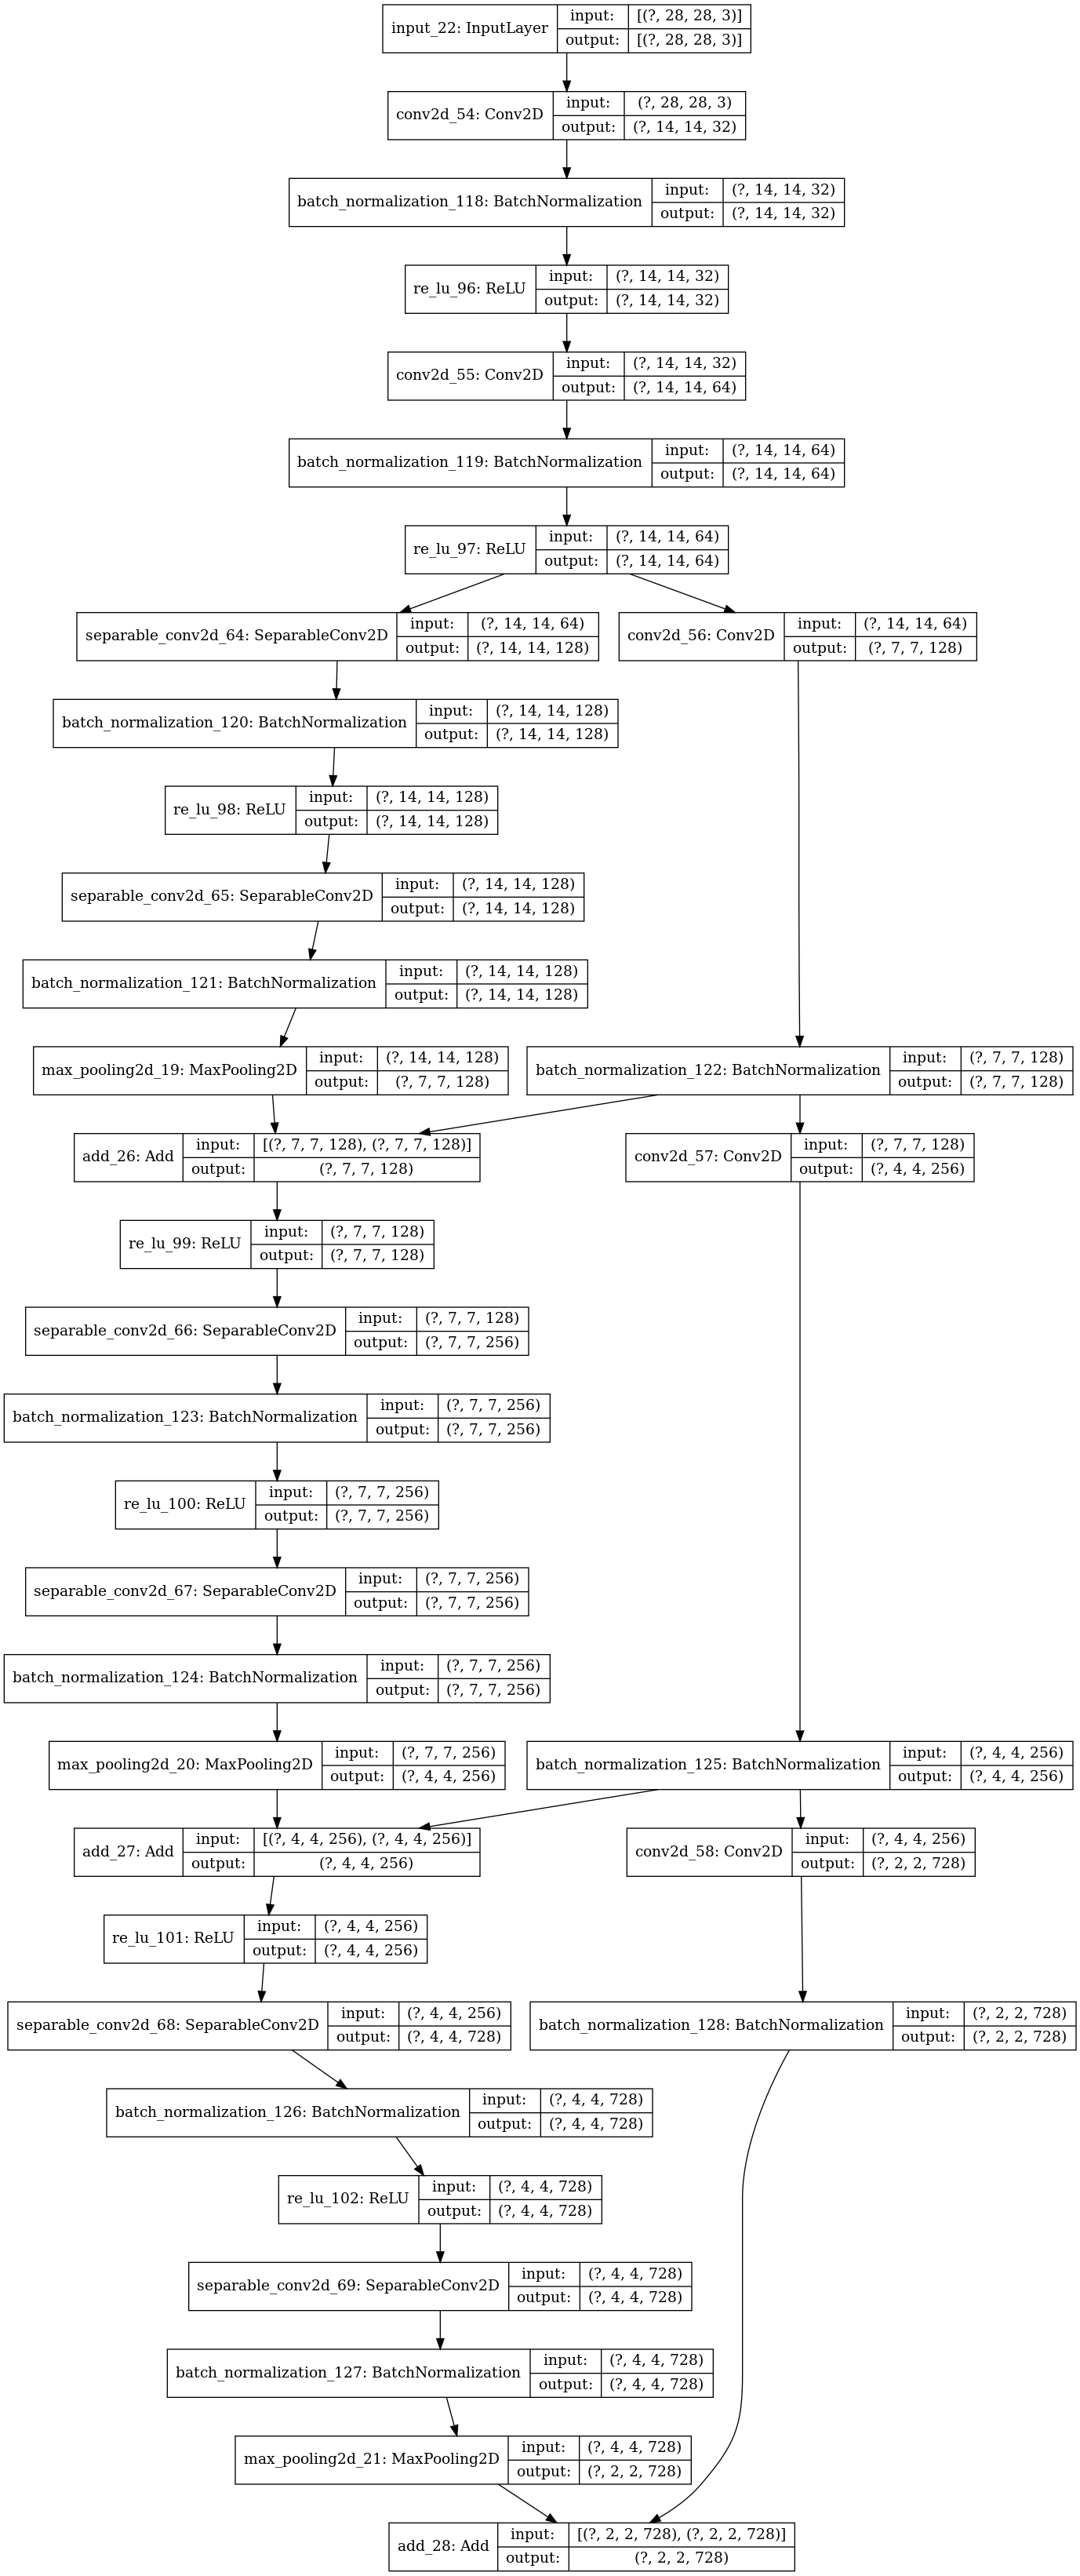

In [31]:
# Entry Flow
def entry_flow(x):
    x = conv_bn(x, 32, 3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)    # skip 발생
    
    x = sepconv_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sepconv_bn(x, 128, 3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 128, 1, strides=2)
    x = Add()([tensor, x])

    x = ReLU()(x)
    x = sepconv_bn(x, 256, 3)
    x = ReLU()(x)
    x = sepconv_bn(x, 256, 3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, 256, 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sepconv_bn(x, 728, 3)
    x = ReLU()(x)
    x = sepconv_bn(x, 728, 3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, 728, 1,strides=2)
    x = Add()([tensor,x])
    

    return x

input = Input(shape = (28,28,3))
x = entry_flow(input)
entry_model = Model(inputs=input, outputs=x)
#model.summary()
tf.keras.utils.plot_model(entry_model, to_file='model.png', show_shapes=True)

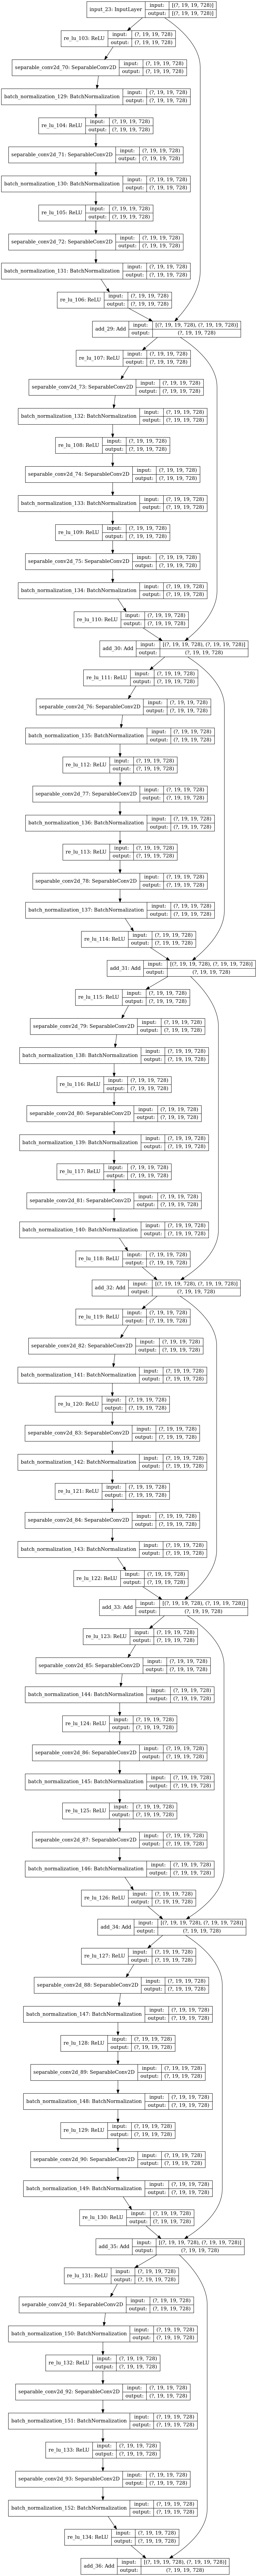

In [32]:
def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sepconv_bn(x, 728, 3)
        x = ReLU()(x)
        x = sepconv_bn(x, 728, 3)
        x = ReLU()(x)
        x = sepconv_bn(x, 728, 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor

input = Input(shape = (19,19,728))
x = middle_flow(input)
moddle_model = Model(inputs=input, outputs=x)
#model.summary()
tf.keras.utils.plot_model(moddle_model, to_file='model.png', show_shapes=True)

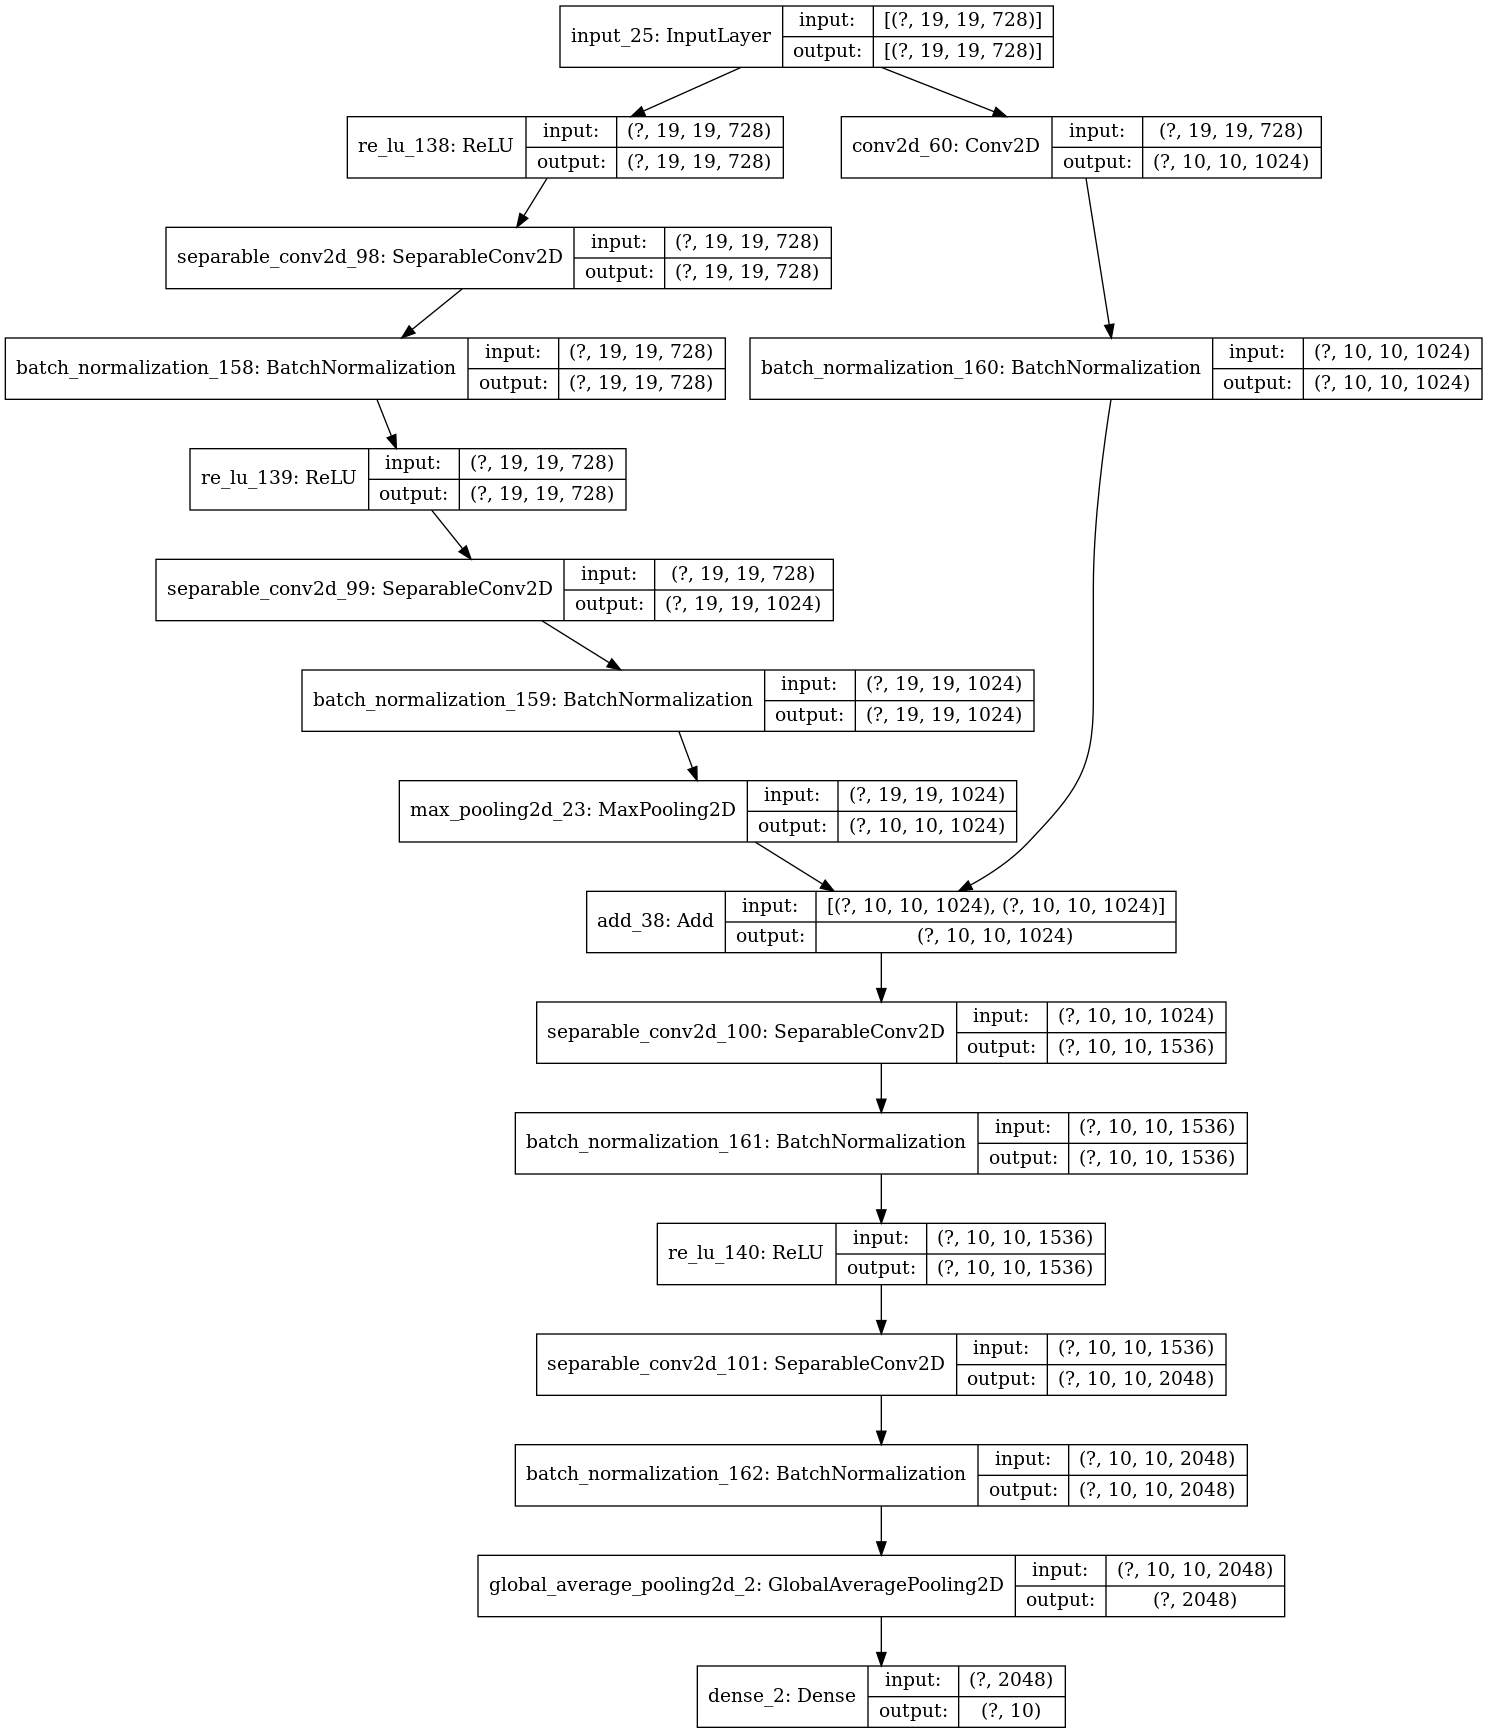

In [34]:
def exit_flow(tensor, classes):
    
    x = ReLU()(tensor)
    x = sepconv_bn(x, 728, 3)
    x = ReLU()(x)
    x = sepconv_bn(x, 1024, 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, 1024, 1, strides =2)
    x = Add()([tensor,x])
    
    x = sepconv_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sepconv_bn(x, 2048, 3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = classes, activation = 'softmax')(x)
    
    return x

input = Input(shape = (19,19,728))
x = exit_flow(input, 10)
exit_model = Model(inputs=input, outputs=x)
#model.summary()
tf.keras.utils.plot_model(exit_model, to_file='model.png', show_shapes=True)

In [37]:
# entire model

def xception(input_shape, classes):
    
    input = Input(shape = input_shape)
    x = entry_flow(input)
    x = middle_flow(x)
    output = exit_flow(x, classes)

    model = Model (inputs=input, outputs=output)
    return model

model=xception((32, 32, 3), 10)
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 16, 16, 32)   864         input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 16, 16, 32)   128         conv2d_67[0][0]                  
__________________________________________________________________________________________________
re_lu_183 (ReLU)                (None, 16, 16, 32)   0           batch_normalization_203[0][0]    
___________________________________________________________________________________________

# Xception 구현 

In [38]:
# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

#constant
BATCH_SIZE = 128
EPOCHS = 20
CLASSES = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = tf.keras.optimizers.RMSprop()

log_dir = '/tmp/logs/xception'

# data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
# normalize
X_train, X_test = X_train / 255.0, X_test / 255.0
# convert to categorical
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, CLASSES)

# use TensorBoard, princess Aurora!
callbacks = [
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir=log_dir)
]

# train
model.compile(loss='categorical_crossentropy', optimizer=OPTIM,
    metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=BATCH_SIZE,
    epochs=EPOCHS, validation_split=VALIDATION_SPLIT, 
    verbose=VERBOSE, callbacks=callbacks) 
score = model.evaluate(X_test, y_test,
                     batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])


Epoch 1/20
313/313 [==============================] - 15s 48ms/step - loss: 1.5215 - accuracy: 0.4433 - val_loss: 2.3478 - val_accuracy: 0.0952
Epoch 2/20
313/313 [==============================] - 13s 43ms/step - loss: 1.0505 - accuracy: 0.6222 - val_loss: 1.6476 - val_accuracy: 0.4074
Epoch 3/20
313/313 [==============================] - 13s 43ms/step - loss: 0.8438 - accuracy: 0.7015 - val_loss: 1.5501 - val_accuracy: 0.5094
Epoch 4/20
313/313 [==============================] - 13s 43ms/step - loss: 0.6815 - accuracy: 0.7616 - val_loss: 1.3590 - val_accuracy: 0.6087
Epoch 5/20
313/313 [==============================] - 13s 42ms/step - loss: 0.5482 - accuracy: 0.8083 - val_loss: 2.3613 - val_accuracy: 0.4438
Epoch 6/20
313/313 [==============================] - 13s 42ms/step - loss: 0.4402 - accuracy: 0.8470 - val_loss: 1.4824 - val_accuracy: 0.6060
Epoch 7/20
313/313 [==============================] - 13s 42ms/step - loss: 0.3500 - accuracy: 0.8784 - val_loss: 1.8951 - val_accuracy: